# Data

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [12]:
df_rwanda = pd.read_csv('./data/rwanda')

X = df_rwanda['mean_light']
y = df_rwanda['wealth_index']

X = np.resize(X, (X.shape[0], 1))
y = np.resize(y, (y.shape[0], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Utils

In [13]:
def plot_regression(estimator, X_train, y_train):
    x_axis = np.linspace(0, 64, 1000).reshape((1000, 1))
    y_axis = estimator.predict(x_axis)
    plt.figure(figsize=(20, 10))
    plt.grid()
    plt.xlim(-1, 64)
    plt.ylim(-2, 5)
    plt.title('Wealth prediction according to nightlight intensity')
    plt.xlabel('nightlight intensity')
    plt.ylabel('wealth')
    plt.scatter(X_train, y_train)
    plt.plot(x_axis, y_axis)
    plt.show()

# Parametric Regression

## Linear Regression

Model : $$Y = X \beta _* + \epsilon$$  
Least squares estimator : $$\beta_n = argmin || Y - X \beta || ^2 _2$$  
Analytical solution : $$\beta_n = (X^T X)^{-1} X^T Y$$  

In [14]:
class LinearRegression:
    
    def __init__(self):
        self.coeff = None
        
    def train(self, X_train, y_train):
        intercept = np.ones((X_train.shape[0], 1))
        X = np.append(intercept, X_train, axis=1)
        beta = scipy.linalg.solve(np.dot(X.T, X), np.dot(X.T, y_train))
        self.coeff = beta
        print("MSE =", np.linalg.norm(y_train - np.dot(X, self.coeff)))
    
    def predict(self, X_test):
        intercept = np.ones((X_test.shape[0], 1))
        X = np.append(intercept, X_test, axis=1)
        y_test = np.dot(X, self.coeff)
        return y_test

MSE = 8.469370903109246
Coefficients : [[-0.33056575]
 [ 0.06853734]]
Prediction : [[0.11150012]]


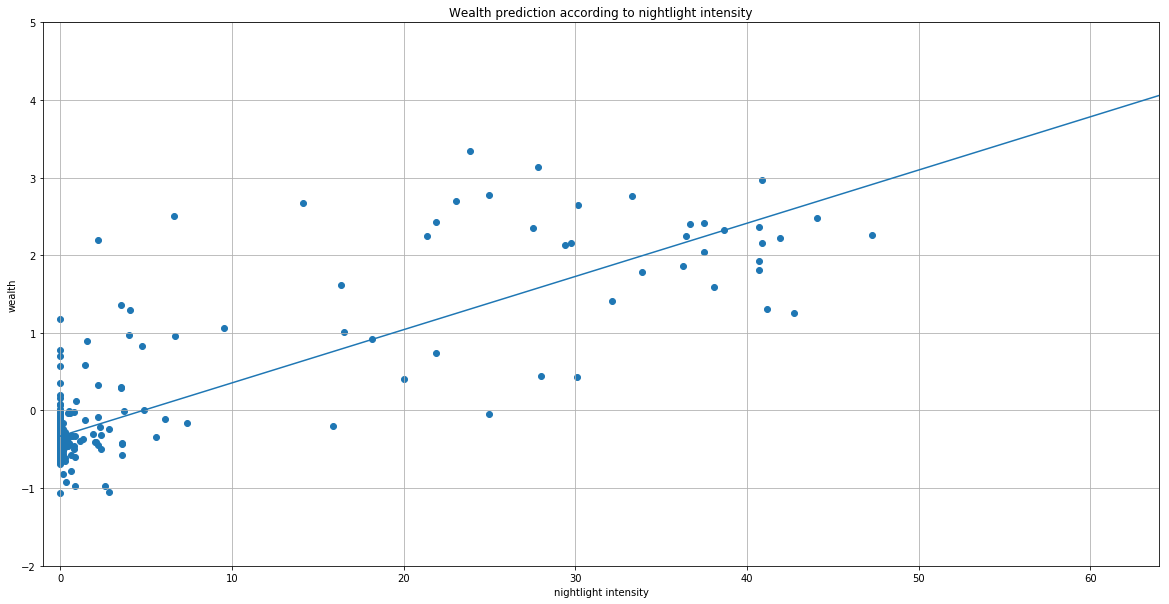

In [16]:
estimator = LinearRegression()
estimator.train(X_train, y_train)

print("Coefficients :", estimator.coeff)
print("Prediction :", estimator.predict(np.array([X_test[11]])))

plot_regression(estimator, X_train, y_train)

## Ridge Regression

Model : $$Y = X \beta_* + \epsilon$$  
Regularized least squares estimator : $$\beta_n = argmin || Y - X \beta || ^2 _2 + \gamma || \beta || ^2 _2$$
Analytical solution : $$\beta_n = (X^T X + \gamma Id)^{-1} X^T Y$$  

In [17]:
class RidgeRegression:
    
    def __init__(self, gamma):
        self.coeff = None
        self.gamma = gamma
        
    def train(self, X_train, y_train):        
        intercept = np.ones((X_train.shape[0], 1))
        X = np.append(intercept, X_train, axis=1)
        beta = scipy.linalg.solve(np.dot(X.T, X) + self.gamma * np.identity(X.shape[1]), np.dot(X.T, y_train))
        #beta = np.dot(X.T, np.linalg.inv(np.dot(X, X.T) + gamma * np.identity(X.shape[0])).dot(y_train))
        self.coeff = beta
        print("MSE =", np.linalg.norm(y_train - np.dot(X, self.coeff)))
    
    def predict(self, X_test):
        intercept = np.ones((X_test.shape[0], 1))
        X = np.append(intercept, X_test, axis=1)
        y_test = np.dot(X, self.coeff)
        return y_test

MSE = 12.28873220039012
Coefficients : [[-0.00142539]
 [ 0.02666342]]
Prediction : [[0.17055369]]


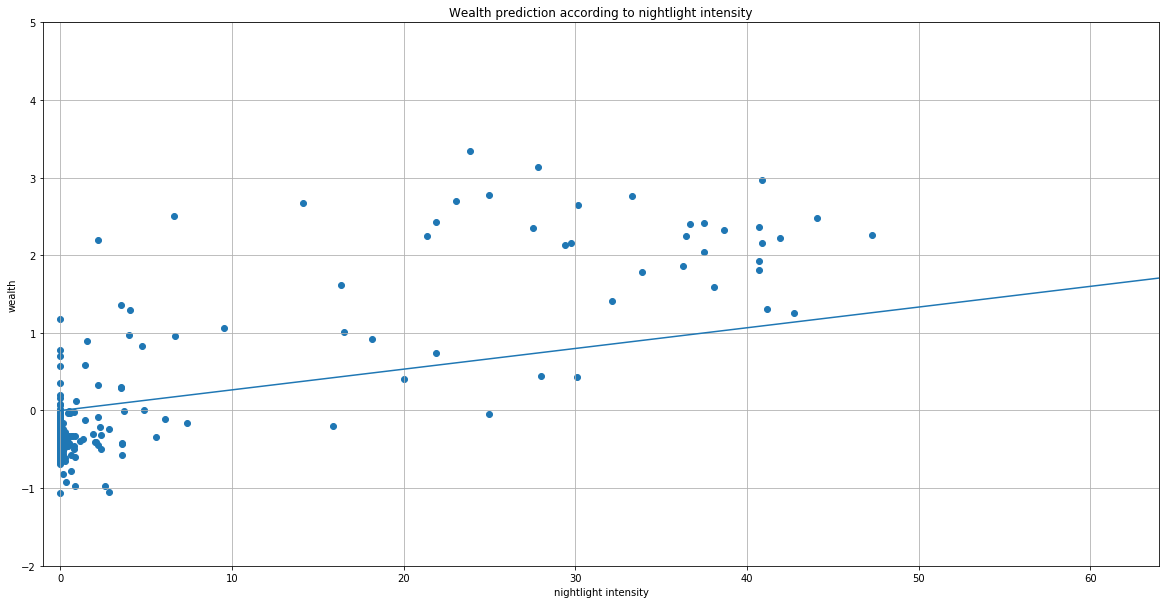

In [19]:
estimator = RidgeRegression(gamma=5e4)
estimator.train(X_train, y_train)

print("Coefficients :", estimator.coeff)
print("Prediction :", estimator.predict(np.array([X_test[11]])))

plot_regression(estimator, X_train, y_train)

## Lasso Regression

Model : $$Y = X \beta_* + \epsilon$$  
Regularized least squares estimator : $$\beta_n = argmin || Y - X \beta || ^2 _2 + \gamma || \beta || _1$$  

## Bayesian Ridge Regression

# Nonparametric Regression

## Smoothing, local linear regression

### k-Nearest-Neighbors Regression

In [261]:
class NearestNeighborsRegression:
    
    def __init__(self, k):
        self.k = k
        self.X = None
        self.y = None
    
    def distance(self, x, y):
        return np.linalg.norm(x - y)
        
    def train(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
    
    def predict(self, X_test):
        y_test = []
        for x_test in X_test:
            distance_matrix = [self.distance(x_test, self.X[i]) for i in range(self.X.shape[0])]
            idx = np.argsort(distance_matrix)[:self.k]
            res = np.mean(y_train[idx])
            y_test.append(res)
        y_test = np.array(y_test)
        return y_test

Prediction : [0.570689]


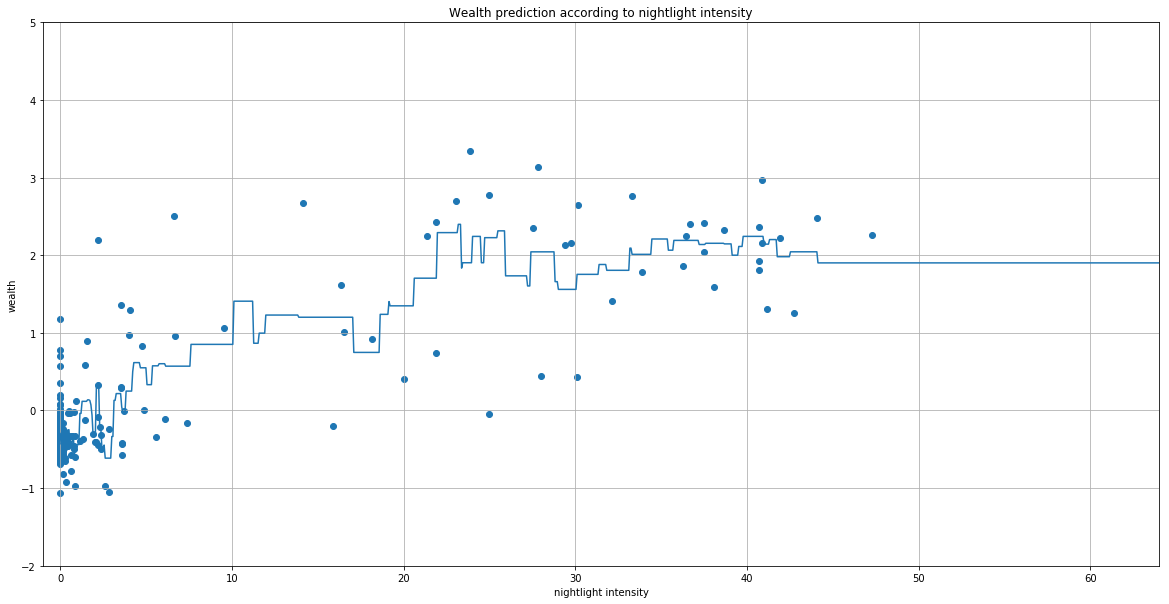

In [275]:
estimator = NearestNeighborsRegression(k=5)
estimator.train(X_train, y_train)

print("Prediction :", estimator.predict(np.array([X_test[11]])))

plot_regression(estimator, X_train, y_train)

### Kernel Smoothing

### Local Linear Regression

In [3]:
class LocallyWeightedLinearRegression:
    
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
        self.X = None
        self.y = None
    
    def kernel(self, x, xi):
        return np.exp(- 0.5 * np.linalg.norm(x - xi)**2 / self.bandwidth**2)
        
    def train(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
    
    def predict(self, X_test):
        
        Y_test = []
        
        for x_test in X_test:
            
            W = np.array([self.kernel(x_test, self.X[i]) for i in range(self.X.shape[0])])

            A = np.zeros((2, 2))
            A[0][0] = np.sum(W)
            A[0][1] = np.dot(W, self.X)
            A[1][0] = A[0][1]
            A[1][1] = np.dot(W, self.X**2)

            b = np.zeros((2, 1))
            b[0][0] = np.dot(W, self.y)
            b[1][0] = np.dot(W, np.multiply(self.y, self.X))

            beta = scipy.linalg.solve(A, b)

            x = np.zeros((2, 1))
            x[0][0] = 1
            x[1][0] = x_test[0]
            y_test = np.dot(x.T, beta)
            Y_test.append(y_test)
        
        Y_test = np.array(Y_test)
        Y_test = np.resize(Y_test, (1000, 1))
        
        return Y_test

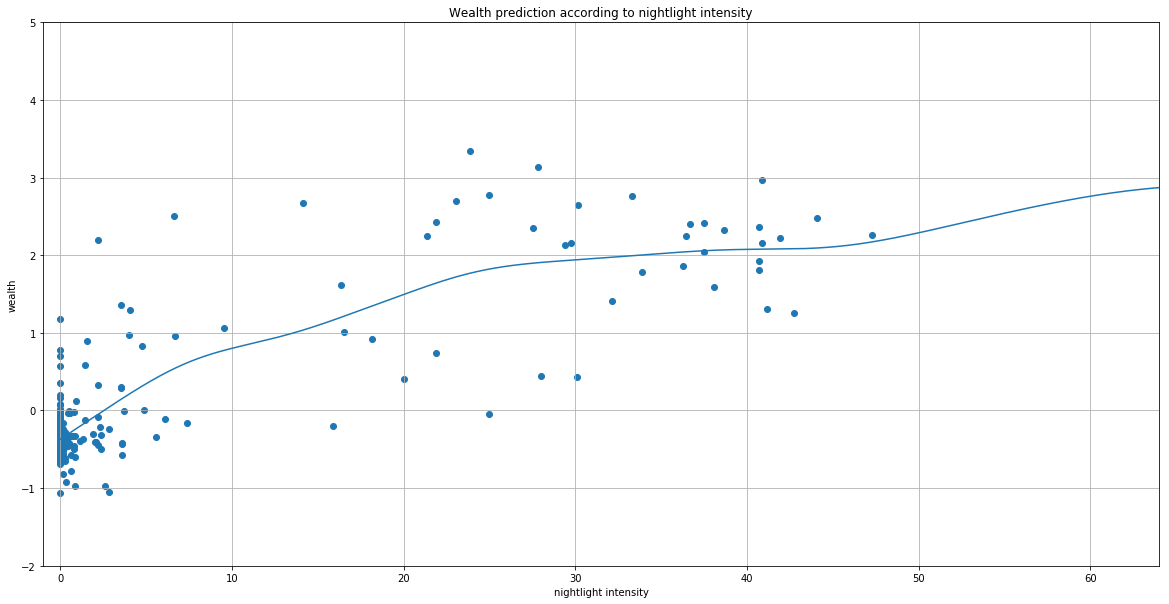

In [10]:
estimator = LocallyWeightedLinearRegression(bandwidth=5.)
estimator.train(X_train, y_train)

#print("Prediction :", estimator.predict(np.array([X_test[11]])))

plot_regression(estimator, X_train, y_train)

### Local Polynomial Regression

### SVR

## Projection on a functional basis, kernel regression

### Polynomial basis

In [191]:
class PolynomialRegression:
    
    def __init__(self, p):
        self.coeff = None
        self.p = p
    
    def phi(self, x, j):
        return x**j
        
    def train(self, X_train, y_train):
        n = X_train.shape[0]
        psi = [[self.phi(X_train[i], j) for j in range(self.p)] for i in range(n)]
        psi = np.resize(psi, (np.shape(psi)[0], np.shape(psi)[1]))
        
        alpha = scipy.linalg.solve(np.dot(psi.T, psi), np.dot(psi.T, y_train))
        self.coeff = alpha
        
        print("MSE =", np.linalg.norm(y_train - np.dot(psi, self.coeff)))
    
    def predict(self, X_test):
        m = X_test.shape[0]
        psi_test = [[self.phi(X_test[i], j) for j in range(self.p)] for i in range(m)]
        psi_test = np.resize(psi_test, (np.shape(psi_test)[0], np.shape(psi_test)[1]))
        y_test = np.dot(psi_test, self.coeff)
        return y_test

MSE = 7.888425561332195
Coefficients : [[-3.70718869e-01]
 [ 1.58477847e-01]
 [-3.51093841e-03]
 [ 2.70939581e-05]]
Prediction : [[0.51266971]]


MSE = 7.83074108427108
Coefficients : [[-3.63242146e-01]
 [ 8.44839901e-03]
 [ 6.09037669e-02]
 [-6.28276309e-03]
 [-9.25339257e-05]
 [ 4.60507039e-05]
 [-2.86971054e-06]
 [ 8.16381383e-08]
 [-1.13153969e-09]
 [ 6.18941659e-12]]
Prediction : [[0.7210504]]


/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/ipykernel_launcher.py:15: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.408195e-30
  from ipykernel import kernelapp as app


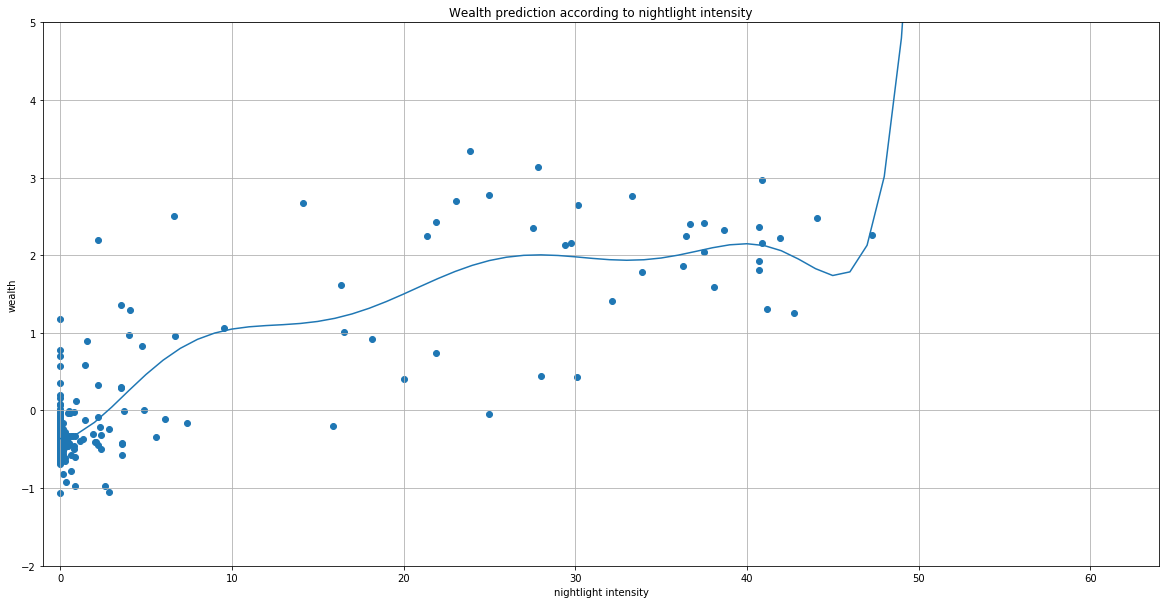

In [249]:
estimator = PolynomialRegression(p=10)
estimator.train(X_train, y_train)

print("Coefficients :", estimator.coeff)
print("Prediction :", estimator.predict(np.array([X_test[11]])))

plot_regression(estimator, X_train, y_train)

### Gaussian basis

In [253]:
class GaussianRegression:
    
    def __init__(self, p):
        self.coeff = None
        self.p = p
    
    def phi(self, x, j):
        mu = np.linspace(0, 64, self.p+1)
        return np.exp(- 0.5 * (x - mu[j]) / 10**2)
        
    def train(self, X_train, y_train):
        n = X_train.shape[0]
        psi = [[self.phi(X_train[i], j) for j in range(self.p)] for i in range(n)]
        psi = np.resize(psi, (np.shape(psi)[0], np.shape(psi)[1]))
        
        alpha = scipy.linalg.solve(np.dot(psi.T, psi), np.dot(psi.T, y_train))
        self.coeff = alpha
        
        print("MSE =", np.linalg.norm(y_train - np.dot(psi, self.coeff)))
    
    def predict(self, X_test):
        m = X_test.shape[0]
        psi_test = [[self.phi(X_test[i], j) for j in range(self.p)] for i in range(m)]
        psi_test = np.resize(psi_test, (np.shape(psi_test)[0], np.shape(psi_test)[1]))
        y_test = np.dot(psi_test, self.coeff)
        return y_test

MSE = 15.715896196255603
Coefficients : [[ 0.00806985]
 [-0.05636192]
 [-0.02993425]
 [-0.05158882]
 [-0.00608952]
 [-0.01505732]
 [-0.04616531]
 [-0.00120223]
 [ 0.04790208]
 [ 0.02828742]]
Prediction : [[-0.11740243]]


/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/ipykernel_launcher.py:16: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.132736e-17
  app.launch_new_instance()


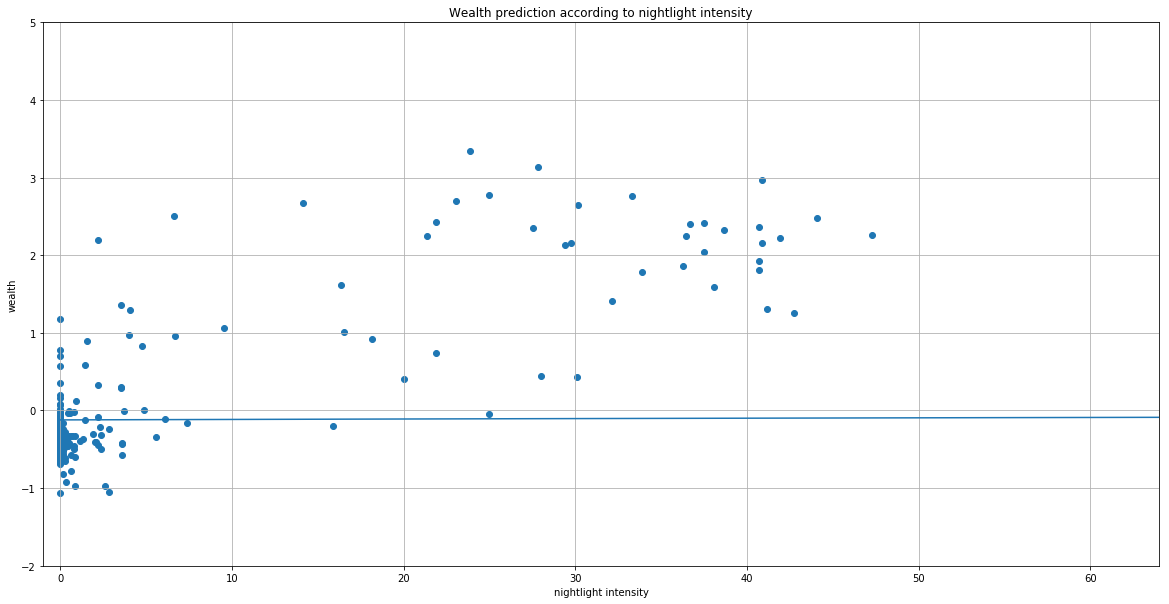

In [254]:
estimator = GaussianRegression(p=10)
estimator.train(X_train, y_train)

print("Coefficients :", estimator.coeff)
print("Prediction :", estimator.predict(np.array([X_test[11]])))

plot_regression(estimator, X_train, y_train)

### Kernel Ridge Regresion

## Locally Adaptive Regression

### Wavelets Regression

## Gaussian Process Regression

# Model selection